# Initialization

In [1]:
!pip install signatory
!pip install Biopython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.2 MB/s 
  Created wheel for signatory: filename=signatory-1.2.6.1.9.0-cp37-cp37m-linux_x86_64.whl size=7554416 sha256=dc0928f5a0046c41124448cc6a3cce312f9c108a406649e51e65cda1c90a4531
  Stored in directory: /root/.cache/pip/wheels/12/ff/e5/ffe613433c810f7f82da6e0c55abd15f4cc04960f8137db53b
Successfully built signatory
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 5.1 MB/s 


In [2]:
import numpy as np
import signatory
from Bio.PDB import *
import torch
import torch.nn.functional as nnf
import torchvision.transforms.functional as F
import tqdm
import matplotlib.pyplot as plt
#  %matplotlib notebook
# Remove the above comment line to activate interactive plot. Not supported in Colab
from mpl_toolkits.mplot3d import Axes3D
import torch.nn
import Bio
from Bio.PDB import PDBList

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebook/alphafold_pytorch-29bd20b0ca0ccd31d984a7dc53f0302d945a2ddc/")

In [5]:
parser = PDBParser()
pdbl = PDBList( )

# Get protein backbone from .pdb file

This is the function to get the list Backbone atom coordinates of proteins. Input 'path' is a folder contains pdb files and the function gives a list of backbone of these proteins. Here we only consider the proteins with a single polypeptide chain. 

In [6]:
def get_BackboneList(path):
  BackboneList=[]
  files = os.listdir(path)
  for pdb_file in files:
    structure = parser.get_structure("MyProtein", path + pdb_file)
    Backbone = [] #So we only consider the protein with a single chain.
    if len(structure) != 1:
      continue
    for chains in structure:
      for chain in chains:
          for residue in chain:
            for atom in residue:
                if (atom.get_name() in ['N','CA','C']):         
                  coord = list(atom.get_coord())
                  Backbone += [coord]
    if len(Backbone) == 0:
      print(pdb_file)
    BackboneList.append(torch.tensor(Backbone))
  print(len(BackboneList))
  return(BackboneList)

In [10]:
path = 'PDB_small_sample/'
BackboneList = get_BackboneList(path)

FileNotFoundError: ignored

In [ ]:
print(len(BackboneList)) #number of sequences
print(BackboneList[0].size()) #length of sequence * 3

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
x1,y1,z1 = np.transpose(BackboneList[0])
ax.plot(x1,y1,z1)
fig.suptitle('Backbone of protein')
plt.show()

# Data-cropping for prediction
The following are functions used for sequence normalization, segmentation and concatenation.<br>

The reason we normalize input segments is to make our model (3D coordinate version) translation invariant. The function **rotation_Transform(path)** normalizes the segments by making them start from the same point and same plane. Starting from the origin, the frist bond of the segment is parallel to the x-axis and the first three points are on the x-z plane.
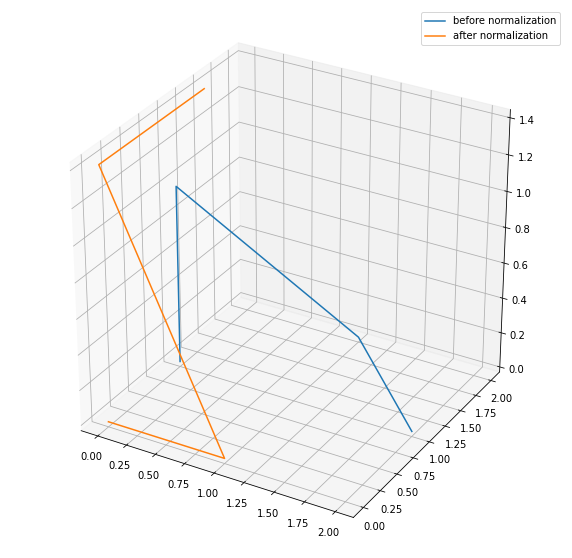

For prediction, we crop paths with a three-point overlap between consecutive segments in order to reconstruct the prediction for segments back to a whole path. We do this because the segments from dummy path have been normalized by rotation and translation before prediction so the prediction of the segments cannot be concatenated directly. We concatenate two consecutive segments by making the overlaped three points on the same plane and as close as possible.

So for prediction, we do the following:
1. run **make_Segment(path, window_size)** to make segments of the dummy path.
2. normalize each segment in the output of **make_Segment(path, window_size)** using **rotation_Transform(path)**.
3. predict the structured path using our CDE model with normalized segments as input.
2. run **concat_Segments(path, window_size)** to concatenate the output segments back to a full path.

In [11]:
def rotation_Transform(path): # path is a list of points in the backbone or a tensor of size (number of points * 3)
  def normalize(v):
      norm = np.linalg.norm(v)
      if norm == 0: 
        return v
      return v / norm
  o1 = np.matrix([0,0,0]).T
  M1 = np.matrix([[1,0,0],[0,1,0],[0,0,1]])
  o2 = np.matrix(path[0]).T
  v1 = normalize(np.array(path[1])-np.array(path[0]))
  v2 = normalize(np.cross(np.array(path[2])-np.array(path[1]), np.array(path[1])-np.array(path[0])))
  v3 = np.cross(v1, v2)
  M2 = np.matrix([v1,v2,v3]).T
  path_transformed = [torch.tensor(np.matmul(np.transpose(M2), o1-o2+M1 * np.matrix(p).T)) for p in path]
  path_transformed = torch.squeeze(torch.stack(path_transformed,dim = 0))
  return path_transformed # output is the normalised path which is a tensor of size (number of points * 3)

  ##first two bond cannot be parallel

/usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/proj3d.py:189: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/proj3d.py:189: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, np.ones_like(xs)])


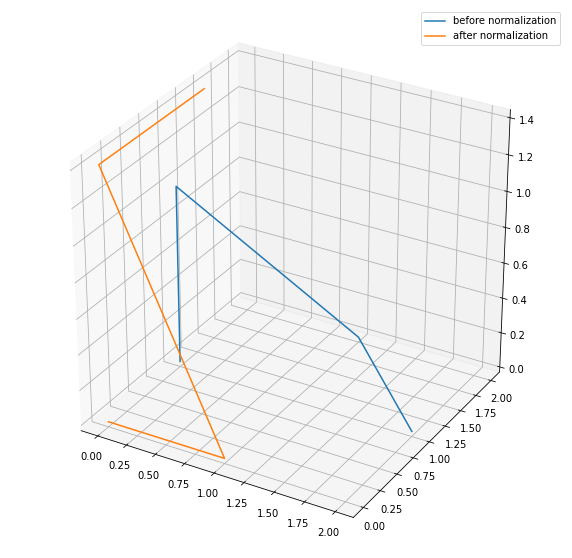

In [95]:
test_path = torch.tensor([[0,1,0],[0,1,1],[1,2,0],[2,1,0]])
new_path = rotation_Transform(test_path)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
x1,y1,z1 = np.transpose(test_path)
line1 = ax.plot(x1,y1,z1, label='before normalization')
x2,y2,z2 = np.transpose(new_path)
line2 = ax.plot(x2,y2,z2, label='after normalization')
ax.legend(['before normalization', 'after normalization'])
plt.show()

In [13]:
# The function gives the rotation matrix which rotates vec1 to vec2 around the origin
def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    if torch.equal(vec1.float(),vec2.float()):
       return torch.eye(3,3,dtype = float)
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return torch.from_numpy(rotation_matrix)

In [15]:
## test for rotation_matrix_from_vectors
vec1 = torch.tensor([2, 3, 2.5])
vec2 = torch.tensor([2,3,2.5])

mat = rotation_matrix_from_vectors(vec1, vec2)
vec1_rot = torch.matmul(mat,torch.tensor(vec1).double())
vec1_rot

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


tensor([2.0000, 3.0000, 2.5000], dtype=torch.float64)

In [85]:
# This function is to concatenate the end of seg1 to the start of seg2 by rotating
# seg2 to make the first three atoms of seg2 match the last three atoms of seg1.
# Input seg are tensors with the size (number of points * 3)
# the output is a tensor with size (number of points * 3), and dtype=torch.float64.
def concat_twoseg(seg1,seg2):
  from scipy.spatial.transform import Rotation as R
  if seg1 == None:
    seg2 = seg2.clone()
    return seg2
  if seg2 == None:
    seg1 = seg1.clone()
    return seg1
  seg1 = seg1.clone()
  seg2 = seg2.clone()
  trans_vec1 = seg1[-1] - seg2[2]
  seg2 += trans_vec1#make the last element of seg1 match the third last segment of seg2
  trans_vec2 = seg2[2]
  seg2 = seg2 - trans_vec2#move the origin to the last point of seg1
  a = torch.stack((seg1[-2]-seg1[-1], seg1[-3]-seg1[-1]), 0)
  b = torch.stack((seg2[1]-seg2[2], seg2[0]-seg2[2]), 0)
  r = R.align_vectors(a, b)#get rotation matrix to align two pairs of vectors
  seg2_r1 = torch.tensor(r[0].apply(seg2))
  seg2_r1 = seg2_r1 + trans_vec2#move the origin back
  seg = torch.concat((seg1, seg2_r1[3:,:]), 0)
  return seg

In [15]:
# path is a backbone coordinate, a tensor of size (number of points * 3)
# window_size is the length of each segment, giving a three point-overlap between segments
# return of this function is a list of segments with each element being a tensor of size(window_size * 3)
# the last segment covers the last point of the path and its length is window-size
def make_Segment(path, window_size): 
  jump = window_size - 3
  if (len(path)-3)%jump==0:
    num_of_seg = (len(path)-3)//jump
  if (len(path)-3)%jump!=0:
    num_of_seg = (len(path)-3)//jump + 1
  segments = []
  for i in range(0,num_of_seg - 1):
    segments.append(path[jump*i:jump*i+window_size,:])
  segments.append(path[-window_size:,:])
  return segments

In [56]:
# segments is a list of segments with each element being a tensor of size(window_size * 3)
# length is the total length of backbone
def concat_Segments(segments, window_size, length):
  number_segment = len(segments)
  len_lastSeg = (length + (number_segment-1)*3) % window_size
  if len_lastSeg == 0:
    len_lastSeg = window_size
  path = None
  for i in range(0,number_segment - 1):
    path = concat_twoseg(path, segments[i])
  path = concat_twoseg(path, segments[-1][-len_lastSeg:]) # overlap of the last segment is not 3, take it separately
  assert len(path) == length
  return path

In [102]:
print(BackboneList[0][0:14])

tensor([[25.0600, 50.6570, 14.5450],
        [24.2180, 50.3670, 15.7320],
        [24.7180, 49.2260, 16.7210],
        [25.8120, 48.5220, 16.3810],
        [26.4880, 47.5810, 17.2980],
        [27.5290, 46.7020, 16.5820],
        [27.7160, 45.4560, 17.0270],
        [28.5730, 44.5050, 16.2990],
        [28.0870, 43.0820, 16.4770],
        [28.0960, 42.2880, 15.3990],
        [27.6410, 40.8970, 15.4520],
        [28.5100, 40.0250, 14.5630],
        [28.4280, 38.7230, 14.7980],
        [29.0320, 37.7500, 13.9150]])


In [ ]:
path = BackboneList[0][0:14]
# print('path ' + str(path))
window_size = 7
original_position = path[0:3]
seg_list = make_Segment(path, window_size)
# print('seg_list ' + str(seg_list))
seg_norm = [rotation_Transform(v) for v in seg_list]
# print('seg_norm' + str(seg_norm))
seg_concat = concat_Segments(seg_norm, window_size, len(path))
# print('seg_concat' + str(seg_concat))
path_back = concat_twoseg(original_position, seg_concat)
# print('path_back' + str(path_back))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
x1,y1,z1 = np.transpose(path)
ax.plot(x1,y1,z1)
x2,y2,z2 = np.transpose(path_back)
ax.plot(x2,y2,z2)
plt.show()

path01 = seg_norm[0]
path02 = seg_norm[1]
path03 = concat_twoseg(path01, path02)
print(path03)

path11 = seg_list[0]
path12 = seg_list[1]
path13 = concat_twoseg(path11, path12)
print(path13)

path23 = concat_twoseg(original_position, path03)
print(path23)

for i in range(8):
  print(i)
  print(np.linalg.norm(path13[i+1]-path13[i])) ##list_concat/original path
  print(np.linalg.norm(path03[i+1]-path03[i])) ##norm_concat
  print(np.linalg.norm(path23[i+1]-path23[i])) ##trans_back


# Others

In [1]:
def get_phi_psi(predict_result,output_angle):

    predict_file=open(predict_result,'r').readlines()
    output_file=open(output_angle,'w')
    
    output_file.write('PHI PSI\n')
    for i in xrange(len(predict_file)):
        #print i
        sin_phi=predict_file[i].strip().split()[0]
        cos_phi=predict_file[i].strip().split()[1]
        sin_psi=predict_file[i].strip().split()[2]
        cos_psi=predict_file[i].strip().split()[3]

        if (cos_phi==0):
            phi_value=90.0
        else:
            phi_value=float(np.arctan2(float(sin_phi),float(cos_phi)))*180/3.1415926
        if (cos_psi==0):
            psi_value=90.0
        else:
            psi_value=float(np.arctan2(float(sin_psi),float(cos_psi)))*180/3.1415926

        phi_value_2 = float("{0:.2f}".format(phi_value))
        psi_value_2 = float("{0:.2f}".format(psi_value))
        output_file.write(str(phi_value_2)+' '+str(psi_value_2)+'\n')    

    output_file.close()

In [ ]:
def calculate_MAE(predicted_file,true_file,output_MAE):
    predict_result=open(predicted_file,'r').readlines()
    true_result=open(true_file,'r').readlines()
    output_file=open(output_MAE,'w')
    psi_sum=0.0
    phi_sum=0.0

    for x in xrange(1,len(true_result)):
        phi_P=float(predict_result[x].strip().split(' ')[0])
        psi_P=float(predict_result[x].strip().split(' ')[1])

        phi_E=float(true_result[x].strip().split(' ')[0])
        psi_E=float(true_result[x].strip().split(' ')[1])

        # perform evaluation
        psi_dev = psi_P - psi_E
        phi_dev = phi_P - phi_E
        if psi_dev < -180:
           psi_P = psi_P + 360
        if psi_dev > 180:
           psi_P = psi_P - 360
        if phi_dev < -180:
           phi_P = phi_P + 360
        if phi_dev > 180:
           phi_P = phi_P - 360
        psi_sum += abs(psi_P - psi_E)
        phi_sum += abs(phi_P - phi_E) 

    psi_MAE = psi_sum / len(true_result)
    phi_MAE = phi_sum / len(true_result)

    #np.savetxt(result_summary, out,  fmt='%.5f',delimiter=' ')
    output_file.write('*phi_MAE: '+str(phi_MAE)+' '+'*psi_MAE: '+str(psi_MAE)+'\n')  
    print "*phi_MAE is %.2f " % (phi_MAE)
    print "*psi_MAE is %.2f " % (psi_MAE)

In [2]:
def get_Signature(BackboneList, depth):
  sig = []
  for i in range(len(BackboneList)):
    path = BackboneList[i].unsqueeze(0)
    sig.append(signatory.signature(path, depth)[0])
  sig = torch.stack(sig,dim = 0)
  return sig

In [3]:
import scipy
from scipy.optimize import linprog
def in_hull(points, x):
    n_points = len(points)
    n_dim = len(x)
    c = np.zeros(n_points)
    A = np.r_[points.T,np.ones((1,n_points))]
    b = np.r_[x, np.ones(1)]
    lp = linprog(c, A_eq=A, b_eq=b)
    return lp.success

sig = get_Signature(BackboneList, 2)
for i in range(len(BackboneList)):
  p = sig[i]
  points = np.delete(sig, i, 0)
  if in_hull(points, p):
    print(f'point {i} is not linearly separable from others')

NameError: ignored

For signature depth=2, the signature space has dimension 12. We calculate the signature with depth=2 for the backbone of each of the 512 selected proteins and found that each of them can be linearly separated in the signature space.

In [ ]:
from scipy.spatial import ConvexHull
from scipy.spatial import Delaunay

for i in range(len(BackboneList)):
  p = sig[i]
  points = np.delete(sig, i, 0)
  tri = Delaunay(points)
  print(i)
  print(tri.find_simplex(p))

In [ ]:
pathA = 'ProteinPDB/AlphaProtein/'
Backbone_Alpha = get_BackboneList(pathA)
pathB = 'ProteinPDB/BetaProtein/'
Backbone_Beta = get_BackboneList(pathB)

In [ ]:
print(len(Backbone_Alpha))
print(Backbone_Alpha[0].size())
print(len(Backbone_Beta))
print(Backbone_Beta[0].size())

In [ ]:
sigA = get_Signature(Backbone_Alpha, 2)
sigB = get_Signature(Backbone_Beta, 2)


In [ ]:
pip install umap-learn

In [ ]:
from numpy.ma.core import concatenate
import umap
reducer = umap.UMAP()
sig_data = concatenate((sigA, sigB), axis=0)
embedding = reducer.fit_transform(sig_data)
embedding.shape

In [ ]:
plt.scatter(embedding[:, 0], embedding[:, 1],
            c= [0]*len(sigA)+[1]*len(sigB))

In [ ]:
!bash feature.sh